This notebook for fine-tuning the PaliGemma model wit the RISCM dataset and testing some model performance improvement suggestions.

Install the required packages with the following commands.

In [1]:
!pip install -U pip setuptools wheel

# "jax[cpu]"==0.4.20
!pip install \
    "jax[cuda12]"==0.4.20 \
    jaxlib==0.4.20 \
    flax==0.7.5 \
    tensorflow==2.15.0 \
    keras==2.15.0 \
    einops~=0.7 \
    pillow \
    scikit-image \
    matplotlib \
    sentencepiece \
    overrides \
    ml_collections \
    kagglehub \
    polars \
    wandb \
    ipython \
    gensim \
    bert-score \
    rouge_score \
    textstat \
    language-tool-python \
    pycocoevalcap \
    hf_xet \
    numpy \
    scipy \
    pot

!apt-get update
!apt-get install -y openjdk-17-jdk
!update-alternatives --set java /usr/lib/jvm/java-17-openjdk-amd64/bin/java
!update-alternatives --set javac /usr/lib/jvm/java-17-openjdk-amd64/bin/javac

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 18.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 56.7 MB/s eta 0:00:00
  Attempting uninstall: setuptools
    Found existing installation: setuptools 75.2.0
    Uninstalling setuptools-75.2.0:
      Successfully uninstalled setuptools-75.2.0
  Attempting uninstall: pip
    Found existing installation: pip 24.1.2
    Uninstalling pip-24.1.2:
      Successfully uninstalled pip-24.1.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ipython 7.34.0 requires jedi>=0.16, which is not installed.


  Preparing metadata (setup.py) ... done
INFO: pip is looking at multiple versions of optax to determine which version is compatible with other requirements. This could take a while.
INFO: pip is looking at multiple versions of chex to determine which version is compatible with other requirements. This could take a while.
INFO: pip is looking at multiple versions of orbax-checkpoint to determine which version is compatible with other requirements. This could take a while.
INFO: pip is still looking at multiple versions of orbax-checkpoint to determine which version is compatible with other requirements. This could take a while.
INFO: This is taking longer than usual. You might need to provide the dependency resolver with stricter constraints to reduce runtime. See https://pip.pypa.io/warnings/backtracking for guidance. If you want to abort this run, press Ctrl + C.
INFO: pip is looking at multiple versions of tensorstore to determine which version is compatible with other requirements.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Download the modified "big_vision_repo" to use PaliGemma utilities.

In [2]:
import os
import sys

# Fetch big_vision repository if python doesn't know about it and install
# dependencies needed for this notebook.
if not os.path.exists("big_vision_repo"):
    !git clone --quiet --branch=master --depth=1 https://github.com/ErenNarin/modified-big-vision big_vision_repo  # TODO: merge to master

# Append big_vision code to python import path
if "big_vision_repo" not in sys.path:
    sys.path.append("big_vision_repo")

Import the required packages and check the availability of jax.

In [3]:
import base64
import functools
import html
import io
import warnings
import json

import jax
import jax.numpy as jnp
import numpy as np
import ml_collections
import polars as pl

import tensorflow as tf
from tensorflow.keras import mixed_precision
import sentencepiece

from IPython.core.display import display, HTML
from PIL import Image

import kagglehub

from skimage.segmentation import slic

from google.colab import userdata

# Import model definition from big_vision
from big_vision_repo.big_vision.models.proj.paligemma import paligemma
from big_vision_repo.big_vision.trainers.proj.paligemma import predict_fns
from big_vision_repo.big_vision.custom_evaluation.evaluation import evaluation_score

# Import big vision utilities
from big_vision_repo.big_vision.datasets.jsonl import DataSource
from big_vision_repo.big_vision.utils import tree_map_with_names, reshard, create_learning_rate_schedule, \
    tree_flatten_with_names
from big_vision_repo.big_vision.sharding import infer_sharding

# Monkey-patch for backwards compatibility
import jax.tree_util
jax.tree = jax.tree_util
jax.tree_util.map = jax.tree_util.tree_map
jax.tree_util.flatten = jax.tree_util.tree_flatten
jax.tree_util.unflatten = jax.tree_util.tree_unflatten
jax.tree_util.leaves = lambda x: jax.tree_util.tree_flatten(x)[0]

from transformers import logging
logging.set_verbosity_error()

# Don't let TF use the GPU or TPUs
tf.config.set_visible_devices([], "GPU")
tf.config.set_visible_devices([], "TPU")

mixed_precision.set_global_policy("mixed_float16")

#backend = jax.extend.backend.get_backend()
devices = jax.devices()
backend_platform = devices[0].platform if devices else "None" # Get platform from the first device if available
print(f"JAX version:  {jax.__version__}")
print(f"JAX platform: {backend_platform}")  # backend.platform
print(f"JAX devices:  {jax.device_count()}")

The dtype policy mixed_float16 may run slowly because this machine does not have a GPU. Only Nvidia GPUs with compute capability of at least 7.0 run quickly with mixed_float16.
If you will use compatible GPU(s) not attached to this host, e.g. by running a multi-worker model, you can ignore this warning. This message will only be logged once
ERROR:jax._src.xla_bridge:Jax plugin configuration error: Plugin module %s could not be loaded
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/jax/_src/xla_bridge.py", line 432, in discover_pjrt_plugins
    plugin_module = importlib.import_module(plugin_module_name)
                    ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.11/importlib/__init__.py", line 126, in import_module
    return _bootstrap._gcd_import(name[level:], package, level)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "<frozen importlib._bootstrap>", line 1204, in _gcd_import
  File "<frozen im

JAX version:  0.4.20
JAX platform: cpu
JAX devices:  1


Download the pre-trained model to be fine-tuned. We will use PaliGemma-2 3B model.

In [4]:
os.environ["KAGGLE_USERNAME"] = userdata.get('KAGGLE_USERNAME')
os.environ["KAGGLE_KEY"] = userdata.get('KAGGLE_KEY')

In [5]:
# Use these for PaliGemma-2 3B 224px²
LLM_VARIANT = "gemma2_2b"
MODEL_PATH = "./paligemma2-3b-pt-224.b16.npz"
KAGGLE_HANDLE = "google/paligemma-2/jax/paligemma2-3b-pt-224"

"""
# Use these for PaliGemma 1:
LLM_VARIANT = "gemma_2b"
MODEL_PATH = "./paligemma-3b-pt-224.f16.npz"
KAGGLE_HANDLE = "google/paligemma/jax/paligemma-3b-pt-224"
"""

if not os.path.exists(MODEL_PATH):
    print("Downloading the checkpoint from Kaggle, this could take a few minutes....")
    MODEL_PATH = kagglehub.model_download(KAGGLE_HANDLE, MODEL_PATH)
    print(f"Model path: {MODEL_PATH}")

TOKENIZER_PATH = "model/paligemma_tokenizer.model"
if not os.path.exists(TOKENIZER_PATH):
    print("Downloading the model tokenizer...")
    !gsutil cp gs://big_vision/paligemma_tokenizer.model {TOKENIZER_PATH}
    print(f"Tokenizer path: {TOKENIZER_PATH}")

100%|██████████| 5.65G/5.65G [00:45<00:00, 133MB/s]


Model path: /root/.cache/kagglehub/models/google/paligemma-2/jax/paligemma2-3b-pt-224/1/./paligemma2-3b-pt-224.b16.npz
/usr/local/lib/python3.11/dist-packages/google/__init__.py:18: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
Copying gs://big_vision/paligemma_tokenizer.model...
- [1 files][  4.1 MiB/  4.1 MiB]                                                
Operation completed over 1 objects/4.1 MiB.                                      
Tokenizer path: model/paligemma_tokenizer.model


Define the model with the pre-trained weights and default config.

In [6]:
# Define model

# IMPORTANT: Gemma-2 has a "final_logits_softcap" property. Set it to 0.0
# for better transfer results.
model_config = ml_collections.FrozenConfigDict({
    "llm": {"vocab_size": 257_152, "variant": LLM_VARIANT, "final_logits_softcap": 0.0},
    "img": {"variant": "So400m/14", "pool_type": "none", "scan": True, "dtype_mm": "float16"}
})
model = paligemma.Model(**model_config)
tokenizer = sentencepiece.SentencePieceProcessor(TOKENIZER_PATH)

# Load params - this can take up to 1 minute in T4 colabs.
params = paligemma.load(None, MODEL_PATH, model_config)

# Define `decode` function to sample outputs from the model.
decode_fn = predict_fns.get_all(model)['decode']
decode = functools.partial(decode_fn, devices=jax.devices(), eos_token=tokenizer.eos_id())

Load all model parameters and add sharding to train the model on multiple GPUs, if available.

In [7]:
# Create a pytree mask of the trainable params.
def is_trainable_param(name, param):  # pylint: disable=unused-argument
    if name.startswith("llm/layers/attn/"):  return True
    if name.startswith("llm/"):              return False
    if name.startswith("img/"):              return False
    raise ValueError(f"Unexpected param name {name}")


trainable_mask = tree_map_with_names(is_trainable_param, params)

# If more than one device is available (e.g. multiple GPUs) the parameters can
# be sharded across them to reduce HBM usage per device.
mesh = jax.sharding.Mesh(jax.devices(), ("data"))

data_sharding = jax.sharding.NamedSharding(
    mesh, jax.sharding.PartitionSpec("data"))

params_sharding = infer_sharding(
    params, strategy=[('.*', 'fsdp(axis="data")')], mesh=mesh)

# Yes: Some donated buffers are not usable.
warnings.filterwarnings(
    "ignore", message="Some donated buffers were not usable")


@functools.partial(jax.jit, donate_argnums=(0,), static_argnums=(1,))
def maybe_cast_to_f32(params, trainable):
    # Cast others to float16, since some GPUs don't support bf16.
    return jax.tree.map(lambda p, m: p.astype(jnp.float32)
    if m else p.astype(jnp.float16),
                        params, trainable)


# Loading all params in simultaneous - albeit much faster and more succinct -
# requires more RAM than the T4 colab runtimes have by default.
# Instead, do it param by param.
params, treedef = jax.tree.flatten(params)
sharding_leaves = jax.tree.leaves(params_sharding)
trainable_leaves = jax.tree.leaves(trainable_mask)
for idx, (sharding, trainable) in enumerate(zip(sharding_leaves, trainable_leaves)):
    params[idx] = reshard(params[idx], sharding)
    params[idx] = maybe_cast_to_f32(params[idx], trainable)
    params[idx].block_until_ready()
params = jax.tree.unflatten(treedef, params)


# Print params to show what the model is made of.
def parameter_overview(params):
    for path, arr in tree_flatten_with_names(params)[0]:
        print(f"{path:80s} {str(arr.shape):22s} {arr.dtype}")


print(" == Model params == ")
parameter_overview(params)

 == Model params == 
img/Transformer/encoder_norm/bias                                                (1152,)                float16
img/Transformer/encoder_norm/scale                                               (1152,)                float16
img/Transformer/encoderblock/LayerNorm_0/bias                                    (27, 1152)             float16
img/Transformer/encoderblock/LayerNorm_0/scale                                   (27, 1152)             float16
img/Transformer/encoderblock/LayerNorm_1/bias                                    (27, 1152)             float16
img/Transformer/encoderblock/LayerNorm_1/scale                                   (27, 1152)             float16
img/Transformer/encoderblock/MlpBlock_0/Dense_0/bias                             (27, 4304)             float16
img/Transformer/encoderblock/MlpBlock_0/Dense_0/kernel                           (27, 1152, 4304)       float16
img/Transformer/encoderblock/MlpBlock_0/Dense_1/bias                             (2

Load and transform the data for using the PaliGemma's DataSource object. While doing this, drop duplicate or partially unavailable samples.

In [8]:
data_path = userdata.get('DATA_PATH')  # Add data path as a Colab secret or give the direct path of the data
images_folder = "resized/"
captions_path = data_path + "captions.csv"

df_input = pl.read_csv(captions_path, separator=",", glob=False)
splits = df_input.select('split').unique()['split'].to_list()
for split in splits:
    filename = f"{data_path}{split}_captions.jsonl"
    if True:  # not os.path.isfile(filename):  # TODO: enable this check
        print(f"{split}_captions not found, starting to process...")
        df_split = df_input.filter(pl.col('split') == split)
        with open(filename, 'w') as f:
            for row in df_split.iter_rows(named=True):
                if os.path.isfile(f"{data_path}{images_folder}{row['image']}"):  # Skip the annotation if referenced image does not exist
                    for i in range(1, 6):
                        json_object = {
                            "prefix": "",
                            "image": f"{images_folder}{row['image']}",
                            "suffix": row[f"caption_{i}"],  # TODO: remove duplicate samples
                        }
                        f.write(json.dumps(json_object) + '\n')
    else:
        print(f"{split}_captions is already processed, skipping...")

test_captions not found, starting to process...
val_captions not found, starting to process...
train_captions not found, starting to process...


Define preprocess and postprocess methods.

In [9]:
def preprocess_image(image, size=224):
    # Model has been trained to handle images of different aspects ratios
    # resized to 224x224 in the range [-1, 1]. Bilinear and antialias resize
    # options are helpful to improve quality in some tasks.

    image = np.asarray(image)
    if image.ndim == 2:  # Convert image without last channel into greyscale.
        image = np.stack((image,) * 3, axis=-1)
    image = image[..., :3]  # Remove alpha layer.
    assert image.shape[-1] == 3

    image = tf.constant(image)
    image = tf.image.resize(image, (size, size), method='bilinear', antialias=True)
    return image.numpy() / 127.5 - 1.0  # [0, 255]->[-1,1]


def preprocess_tokens(prefix, suffix=None, seqlen=None):
    # Model has been trained to handle tokenized text composed of a prefix with
    # full attention and a suffix with causal attention.
    separator = "\n"
    tokens = tokenizer.encode(prefix, add_bos=True) + tokenizer.encode(separator)
    mask_ar = [0] * len(tokens)  # 0 to use full attention for prefix.
    mask_loss = [0] * len(tokens)  # 0 to not use prefix tokens in the loss.

    if suffix:
        suffix = tokenizer.encode(suffix, add_eos=True)
        tokens += suffix
        mask_ar += [1] * len(suffix)  # 1 to use causal attention for suffix.
        mask_loss += [1] * len(suffix)  # 1 to use suffix tokens in the loss.

    mask_input = [1] * len(tokens)  # 1 if it's a token, 0 if padding.
    if seqlen:
        padding = [0] * max(0, seqlen - len(tokens))
        tokens = tokens[:seqlen] + padding
        mask_ar = mask_ar[:seqlen] + padding
        mask_loss = mask_loss[:seqlen] + padding
        mask_input = mask_input[:seqlen] + padding

    return jax.tree.map(np.array, (tokens, mask_ar, mask_loss, mask_input))


def postprocess_tokens(tokens):
    tokens = tokens.tolist()  # np.array to list[int]
    try:  # Remove tokens at and after EOS if any.
        eos_pos = tokens.index(tokenizer.eos_id())
        tokens = tokens[:eos_pos]
    except ValueError:
        pass
    return tokenizer.decode(tokens)

Define the datasets and the data loaders.

In [10]:
SEQLEN = 128

train_dataset = DataSource(
    os.path.join(data_path, "train_captions.jsonl"),
    fopen_keys={"image": data_path}
)

val_dataset = DataSource(
    os.path.join(data_path, "val_captions.jsonl"),
    fopen_keys={"image": data_path})


def train_data_iterator(img_token="grid"):
    """Never ending iterator over training examples."""
    # Shuffle examples and repeat so one can train for many epochs.
    dataset = train_dataset.get_tfdata().shuffle(1_000).repeat()
    for example in dataset.as_numpy_iterator():
        image = Image.open(io.BytesIO(example["image"]))
        image = preprocess_image(image)

        region_masks = None
        if img_token == "segment":
          segments = slic(image, n_segments=(16*16), compactness=1000)
          region_masks = np.stack([(segments == i).astype(np.float32) for i in np.unique(segments)])
          region_masks = jnp.array(region_masks)

        prefix = "caption en"  # Could also be a different prefix per example.
        suffix = example["suffix"].decode().lower()
        tokens, mask_ar, mask_loss, _ = preprocess_tokens(prefix, suffix, SEQLEN)

        yield {
            "image": np.asarray(image),
            "text": np.asarray(tokens),
            "annotation": np.asarray(tokens),
            "mask_ar": np.asarray(mask_ar),
            "mask_loss": np.asarray(mask_loss),
            "region_masks": region_masks
        }


def validation_data_iterator():
    """Single iterator over validation examples."""
    for example in val_dataset.get_tfdata().as_numpy_iterator():
        image = Image.open(io.BytesIO(example["image"]))
        image = preprocess_image(image)

        prefix = "caption en"  # Could also be a different prefix per example.
        tokens, mask_ar, _, mask_input = preprocess_tokens(prefix, seqlen=SEQLEN)

        suffix = example["suffix"].decode().lower()
        tmp_tokens, _, _, _ = preprocess_tokens(prefix, suffix, SEQLEN)

        yield {
            "image": np.asarray(image),
            "text": np.asarray(tokens),
            "annotation": np.asarray(tmp_tokens),
            "mask_ar": np.asarray(mask_ar),
            "mask_input": np.asarray(mask_input)
        }

Display some examples from the training dataset.

Training examples



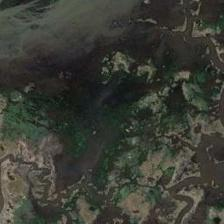
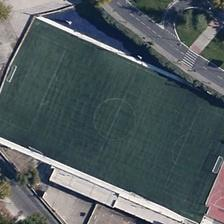
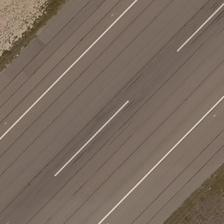

In [11]:
def render_inline(image, resize=(128, 128)):
    """Convert image into inline html."""
    image = Image.fromarray(image)
    image.resize(resize)
    with io.BytesIO() as buffer:
        image.save(buffer, format='jpeg')
        image_b64 = str(base64.b64encode(buffer.getvalue()), "utf-8")
        return f"data:image/jpeg;base64,{image_b64}"


def render_example(image, caption, annotation=None):
    caption = caption.replace(" .", ".").capitalize()
    image = ((image + 1) / 2 * 255).astype(np.uint8)  # [-1,1] -> [0, 255]
    annotation_div = ""
    if annotation:
        annotation_div = f"""
            <br/>
            <p style="width:256px; margin:10px; font-size:small;">{html.escape(annotation)}</p>
        """
    return f"""
    <div style="display: inline-flex; align-items: center; justify-content: center;">
        <img style="width:128px; height:128px;" src="{render_inline(image, resize=(64, 64))}" />
        <p style="width:256px; margin:10px; font-size:small;">{html.escape(caption)}</p>
        {annotation_div}
    </div>
    """

html_out = ""
for idx, example in zip(range(3), train_data_iterator()):
    caption = postprocess_tokens(example["annotation"])  # detokenize model input.
    caption = caption[len("caption en\n"):]  # strip prefix
    html_out += render_example(example["image"], caption)

print("Training examples")
display(HTML(html_out))

Define loss and inference functions.

In [12]:
# The main update_fn using a simple stochastic gradient descent (SGD).
@functools.partial(jax.jit, donate_argnums=(0,))
def update_fn(params, batch, learning_rate):
    imgs, txts, mask_ar, region_masks = batch["image"], batch["text"], batch["mask_ar"], batch["region_masks"]

    def loss_fn(params):
        text_logits, _ = model.apply({"params": params}, imgs, txts[:, :-1], mask_ar[:, :-1], train=True, region_masks=region_masks)
        logp = jax.nn.log_softmax(text_logits, axis=-1)

        # The model takes as input txts[:, :-1] but the loss is defined as predicting
        # next tokens txts[:, 1:]. Additionally, mask_loss[:, 1:] indicates which tokens
        # are part of the loss (e.g. prefix and padded tokens are not included).
        mask_loss = batch["mask_loss"][:, 1:]
        targets = jax.nn.one_hot(txts[:, 1:], text_logits.shape[-1])

        # Compute the loss per example. i.e. the mean of per token pplx.
        # Since each example has a different number of tokens, normalize it.
        token_pplx = jnp.sum(logp * targets, axis=-1)  # sum across vocab_size.
        example_loss = -jnp.sum(token_pplx * mask_loss, axis=-1)  # sum across seq_len.
        example_loss /= jnp.clip(jnp.sum(mask_loss, -1), 1)  # weight by num of tokens.

        # batch_loss: mean of per example loss.
        return jnp.mean(example_loss)

    loss, grads = jax.value_and_grad(loss_fn)(params)

    # Apply gradients to trainable params using SGD.
    def apply_grad(param, gradient, trainable):
        if not trainable: return param
        return param - learning_rate * gradient

    params = jax.tree_util.tree_map(apply_grad, params, grads, trainable_mask)

    return params, loss

# Evaluation/inference loop.
def make_predictions(data_iterator, *, params, num_examples=None,
                     batch_size=4, seqlen=SEQLEN, sampler="greedy"):
    outputs = []
    while True:
        # Construct a list of examples in the batch.
        examples = []
        try:
            for _ in range(batch_size):
                examples.append(next(data_iterator))
                examples[-1]["_mask"] = np.array(True)  # Indicates true example.
        except StopIteration:
            if len(examples) == 0:
                return outputs

        # Not enough examples to complete a batch. Pad by repeating last example.
        while len(examples) % batch_size:
            examples.append(dict(examples[-1]))
            examples[-1]["_mask"] = np.array(False)  # Indicates padding example.

        # Convert list of examples into a dict of np.arrays and load onto devices.
        batch = jax.tree.map(lambda *x: np.stack(x), *examples)
        batch = reshard(batch, data_sharding)

        # Make model predictions
        tokens = decode({"params": params}, batch=batch,
                        max_decode_len=seqlen, sampler=sampler)

        # Fetch model predictions to device and detokenize.
        tokens, mask = jax.device_get((tokens, batch["_mask"]))
        tokens = tokens[mask]  # remove padding examples.
        responses = [postprocess_tokens(t) for t in tokens]

        # Append to html output.
        for example, response in zip(examples, responses):
            caption = postprocess_tokens(example["annotation"])  # detokenize model input.
            caption = caption[len("caption en\n"):]  # strip prefix
            outputs.append((example["image"], response, caption))
            if num_examples and len(outputs) >= num_examples:
                return outputs

Initialize the W&B project and define the hyperparameters to be tested.

In [13]:
import wandb

wandb.login(key=userdata.get('WANDB_KEY'))

PROJECT_NAME = "DI725_project_2389088"

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: erennarin-92 (erennarin-92-metu-middle-east-technical-university) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Start the training with W&B sweeps.

In [14]:
def train(batch_size, epochs, learning_rate, img_token):
    wandb.init(project=PROJECT_NAME)

    BATCH_SIZE = batch_size
    TRAIN_EXAMPLES = epochs
    LEARNING_RATE = learning_rate
    IMG_TOKEN = img_token
    wandb.log({"batch_size": batch_size})
    wandb.log({"epochs": epochs})
    wandb.log({"img_token": IMG_TOKEN})

    TRAIN_STEPS = TRAIN_EXAMPLES // BATCH_SIZE
    EVAL_STEPS = TRAIN_STEPS // 64
    EVAL_EXAMPLES = 6

    train_data_it = train_data_iterator(img_token=IMG_TOKEN)

    train_params = params.copy()

    sched_fn = create_learning_rate_schedule(
        total_steps=TRAIN_STEPS + 1, base=LEARNING_RATE,
        decay_type="cosine", warmup_percent=0.10)

    for step in range(1, TRAIN_STEPS + 1):
        # Make list of N training examples.
        examples = [next(train_data_it) for _ in range(BATCH_SIZE)]

        # Convert list of examples into a dict of np.arrays and load onto devices.
        batch = jax.tree.map(lambda *x: np.stack(x), *examples)
        batch = reshard(batch, data_sharding)

        # Training step and report training loss
        learning_rate = sched_fn(step)
        train_params, loss = update_fn(train_params, batch, learning_rate)

        loss = jax.device_get(loss)
        print(f"step: {step:2d}/{TRAIN_STEPS:2d}   lr: {learning_rate:.5f}   loss: {loss:.4f}")
        wandb.log({"step": step, "learning_rate": learning_rate})
        wandb.log({"step": step, "train_loss": loss})

        if (step % EVAL_STEPS) == 0:
            print(f"Model predictions at step {step}")
            html_out = ""
            sum_score = 0
            for image, caption, annotation in make_predictions(
                    validation_data_iterator(), params=train_params, num_examples=EVAL_EXAMPLES, batch_size=BATCH_SIZE):  # TODO: make multiple predictions and get the average score
                # Evaluation
                caption = caption.replace(" .", ".").capitalize()
                annotation = annotation.replace(" .", ".").capitalize()
                score = evaluation_score(annotation, caption)
                sum_score += score
                html_out += render_example(image, caption, annotation)
            wandb.log({"step": step, "segment_avg_score": sum_score / EVAL_EXAMPLES})
            print(f"Segment average score at step {step}: {sum_score / EVAL_EXAMPLES}")
            display(HTML(html_out))

In [15]:
import itertools

hyperparameters = {
    "batch_size": [4],
    "epochs": [1024],
    "learning_rate": [0.01],
    "img_token": ["segment"]
}

keys = list(hyperparameters.keys())
values = list(hyperparameters.values())

for value in itertools.product(*values):
    config = dict(zip(keys, value))
    print(config)
    train(**config)
    print("Training completed, checking for new configuration.")
print("Training completed.")

Output hidden; open in https://colab.research.google.com to view.